# Diagnoses of Pneumonia using Chest X-ray Image Classification

The author of this notebook is **Dr Raheel Siddiqi**. Dr Raheel Siddiqi is a Senior Assistant Professor at Bahria University, Karachi Campus. 

This notebook presents an experiment (and its results). The objective is to expolit a self-designed *Convolutional Neral Network (CNN)* to diagnose *Pneumonia* on the basis of Chest X-ray. The dataset is downloded from [kaggle.com](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/home).

The dataset contains 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). It is a binary classification problem.

First of all we import all the relevant Python and third party packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

%matplotlib inline

C:\Users\Bahria\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Here we get the names of all the pneumonia and normal x-ray image files. 

In [2]:
total_images_train_normal = os.listdir('C:\\Users\\Bahria\\Chest_X_Ray_Images_Pneumonia\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\NORMAL')
total_images_train_pneumonia = os.listdir('C:\\Users\\Bahria\\Chest_X_Ray_Images_Pneumonia\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\PNEUMONIA')

Now we display some normal x-ray images.

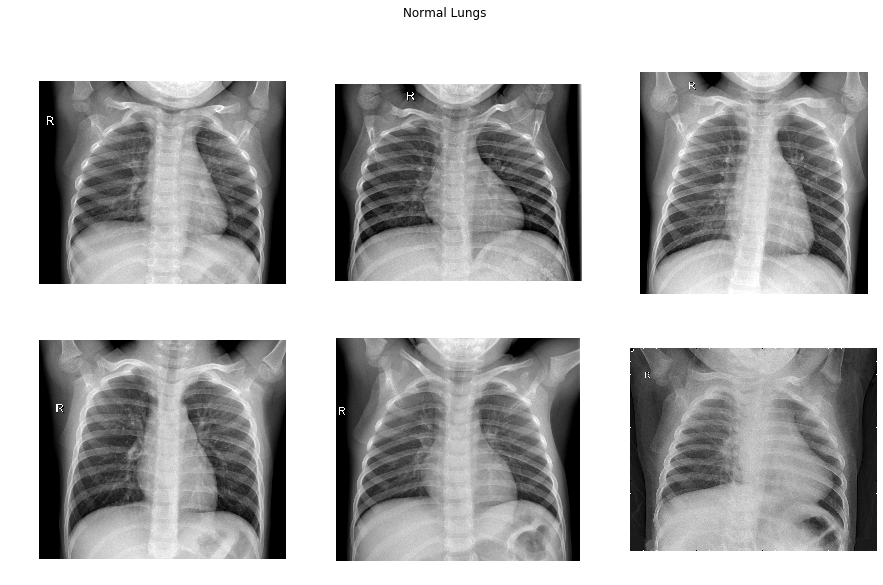

In [3]:
sample_normal = random.sample(total_images_train_normal,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('C:\\Users\\Bahria\\Chest_X_Ray_Images_Pneumonia\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\NORMAL\\'+sample_normal[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Normal Lungs')
plt.show()

Here we display some pneumonia affected x-ray images.

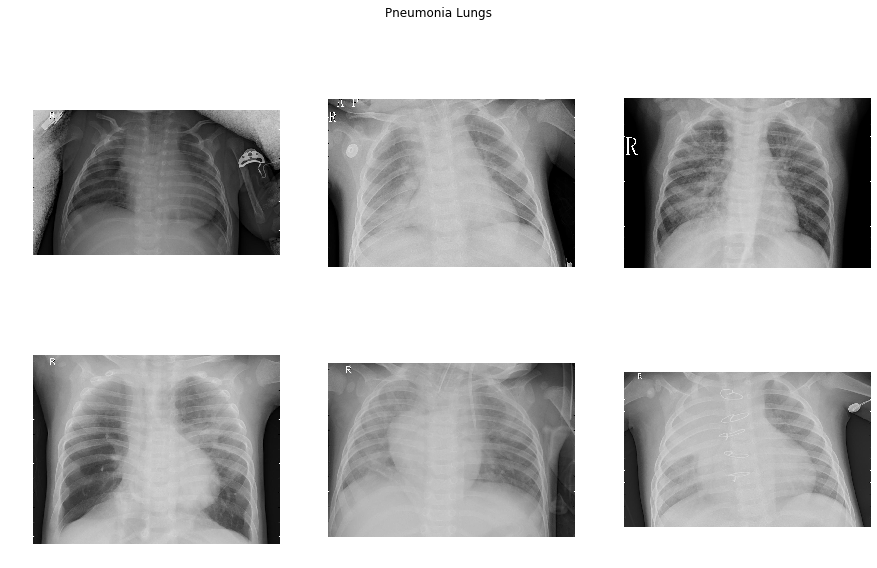

In [4]:
sample_pneumonia = random.sample(total_images_train_pneumonia,6)
f,ax = plt.subplots(2,3,figsize=(15,9))

for i in range(0,6):
    im = cv2.imread('C:\\Users\\Bahria\\Chest_X_Ray_Images_Pneumonia\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\PNEUMONIA\\'+sample_pneumonia[i])
    ax[i//3,i%3].imshow(im)
    ax[i//3,i%3].axis('off')
f.suptitle('Pneumonia Lungs')
plt.show()

Now we compare and visualize the difference in the number of the two types of x-ray images.

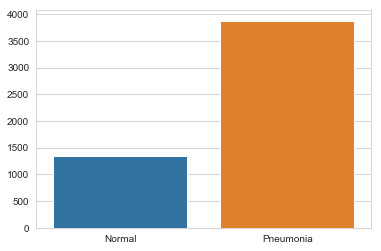

In [5]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[len(total_images_train_normal),len(total_images_train_pneumonia)])

### Model Creation and Compilation

Here we declare some variables for our convenience.

In [6]:
image_height = 150
image_width = 150
batch_size = 10
no_of_epochs  = 15

Here a sequential model is created and compiled.

In [7]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Here we view the details of the model that we have just created.

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)        0         
__________

Here we set our parameters for data augmentation.

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

Here we read batches of training and testing data. 

In [10]:
training_set = train_datagen.flow_from_directory('C:\\Users\\Bahria\\Chest_X_Ray_Images_Pneumonia\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')

test_set = test_datagen.flow_from_directory('C:\\Users\\Bahria\\Chest_X_Ray_Images_Pneumonia\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test',target_size=(image_width, image_height),batch_size=batch_size,class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Setting up a callback so that *learning rate* may be reduced if learning becomes stagnant. 

In [11]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

### Training of Model

In [12]:
history = model.fit_generator(training_set,
                    steps_per_epoch=5216//batch_size,
                    epochs=no_of_epochs,
                    validation_data=test_set,
                    validation_steps=624//batch_size,
                    callbacks=callbacks
                   )

Epoch 1/15
521/521 [==============================] - 529s 1s/step - loss: 0.4439 - acc: 0.7937 - val_loss: 0.3878 - val_acc: 0.8242
Epoch 2/15
521/521 [==============================] - 512s 983ms/step - loss: 0.3196 - acc: 0.8624 - val_loss: 0.3805 - val_acc: 0.8177
Epoch 3/15
521/521 [==============================] - 512s 982ms/step - loss: 0.2708 - acc: 0.8949 - val_loss: 0.3277 - val_acc: 0.8823
Epoch 4/15
521/521 [==============================] - 514s 987ms/step - loss: 0.2306 - acc: 0.9106 - val_loss: 0.2709 - val_acc: 0.9016
Epoch 5/15
521/521 [==============================] - 512s 982ms/step - loss: 0.2046 - acc: 0.9191 - val_loss: 0.5054 - val_acc: 0.8323
Epoch 6/15
521/521 [==============================] - 521s 999ms/step - loss: 0.1785 - acc: 0.9340 - val_loss: 0.6633 - val_acc: 0.8194
Epoch 7/15
521/521 [==============================] - 513s 984ms/step - loss: 0.1786 - acc: 0.9300 - val_loss: 0.3431 - val_acc: 0.8645
Epoch 8/15
521/521 [==============================]

### Visualization of Training and Validation Process

The following part of the code visualizes how the training and validation losses and accuracies evolved with the number of epochs.

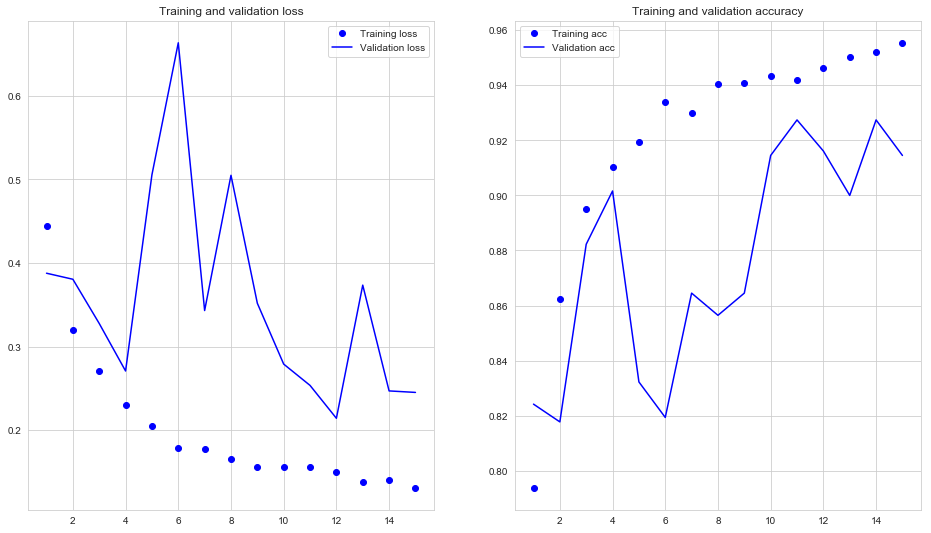

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(16,9))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

### Computing the Final Test-Set Classification Accuracy

Here we calculate our trained model's final classification accuracy.

In [15]:
no_steps = len(test_set)
result = model.evaluate_generator(test_set, steps=no_steps)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 91.51%
